<a href="https://colab.research.google.com/github/sravanikuncham466/DSBA_6165_Forest_Fire_and_Smoke_Detection/blob/main/Without_LWF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import vgg16,resnet, MobileNet
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [ ]:

#print tensorflow version
print(tf.__version__)

2.18.0


In [ ]:
## set train, validation, and test paths
train_path = '/content/drive/MyDrive/farah dl assignment/data _set_fire/Forect Fire/Forest Fire_Dataset/train'
validation_path = '/content/drive/MyDrive/farah dl assignment/data _set_fire/Forect Fire/Forest Fire_Dataset/val'
test_path = '/content/drive/MyDrive/farah dl assignment/data _set_fire/Forect Fire/Forest Fire_Dataset/test'

The dataset is divided into three subsets: training, validation, and test, each containing images categorized into five classes:

* fire
* nofire
* smoke
* smokefire
* haze








**Count Images in Each Folder**

In [ ]:
import os

def count_images(directory):
    class_counts = {}
    total_images = 0
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            count = len(os.listdir(category_path))
            class_counts[category] = count
            total_images += count
    return class_counts, total_images

# Get counts for train, validation, and test sets
train_counts, train_total = count_images(train_path)
val_counts, val_total = count_images(validation_path)
test_counts, test_total = count_images(test_path)

# Print summary
print("Train Data:", train_counts, "Total:", train_total)
print("Validation Data:", val_counts, "Total:", val_total)
print("Test Data:", test_counts, "Total:", test_total)


Train Data: {'smokefire': 810, 'fire': 800, 'nofire': 810, 'haze': 702, 'smoke': 800} Total: 3922
Validation Data: {'nofire': 200, 'haze': 150, 'fire': 207, 'smokefire': 200, 'smoke': 203} Total: 960
Test Data: {'nofire': 210, 'haze': 151, 'smokefire': 200, 'smoke': 200, 'fire': 210} Total: 971


**Training Data**

Distribution:
* fire : 800 images
* nofire : 800 images
* smoke : 820 images
* smokefire: 800 images
* Haze: 702




Total images : 3922

* The training dataset is fairly balanced, with most classes having around 800 images. The haze class has slightly fewer images (702), but this still provides a substantial amount of data for learning.
* The training dataset is the largest, ensuring that the model has enough data to learn patterns.

**Validation Data**

Distribution:
* fire : 200 images
* nofire : 200 images
* smoke : 200 images
* smokefire : 200 images
* Haze: 150

Total Images : 950

* Validation set is balanced across all five classes.

* This ensures that the model performance evaluation is unbiased during training.

* The number of images is much smaller comapred to the training set, as validation is mainly used for tuning hyperparameters and preventing overfitting.

**Test Data**

Distribution:
* fire : 200 images
* nofire : 200 images
* smoke : 200 images
* smokefire : 200 images
* Haze: 151

Total Images : 951

* The test set is balanced across all five classes.
* This ensures the final model is unbiased.
* The test set kept untouched during training to provide realistic estimate of model performance.






 **Check for Corrupt Images**


In [ ]:
import cv2

def check_corrupt_images(directory):
    corrupt_images = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        corrupt_images.append(img_path)
                except:
                    corrupt_images.append(img_path)
    return corrupt_images

# Identify corrupt images
corrupt_train = check_corrupt_images(train_path)
corrupt_val = check_corrupt_images(validation_path)
corrupt_test = check_corrupt_images(test_path)

print(f"Corrupt Train Images: {len(corrupt_train)}")
print(f"Corrupt Validation Images: {len(corrupt_val)}")
print(f"Corrupt Test Images: {len(corrupt_test)}")

# If needed, delete corrupt images
for img in corrupt_train + corrupt_val + corrupt_test:
    os.remove(img)


Corrupt Train Images: 0
Corrupt Validation Images: 0
Corrupt Test Images: 0


* To ensure that only valid images are used , preventing errors during model training we did this step. The goal of this step is to assess the quality of the dataset by identifying and removing corrupt images before training a machine learning model.

* In this step we iterates through all image files in each class.
* Attempts to read each image using cv2.imread(img_path).
* If the image cannot be loaded ( img is none) it is marked as corrupt.
* If any error occurs while reading, the image is added to the corrupt list.

From the output , it is clear that there is no corrupt images were detected across all three subsets.

This means that the dataset is well maintained and free from missing or unreadable image files.

As there is no corrupt images were found, no deletions are required.


**Visualizing**

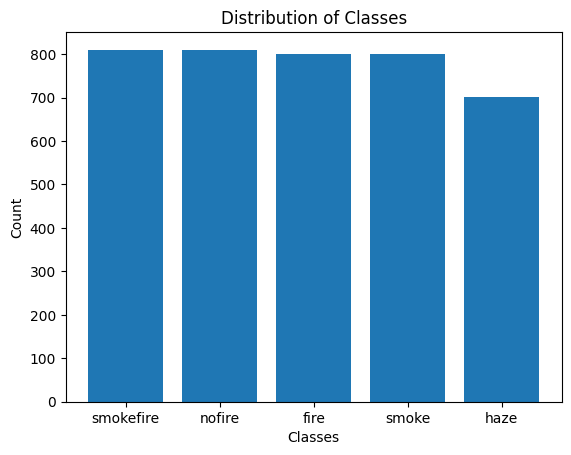

In [ ]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'train' DataFrame
train = create_dataframe(train_path)

# Now you can use 'train' in your code:
class_counts = train['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()




The goal here is to analyze the distribution of different classes in the training dataset by counting the number of images per class and visualizing it using a bar chart.
We use value_counts() to count the number of images in each class.



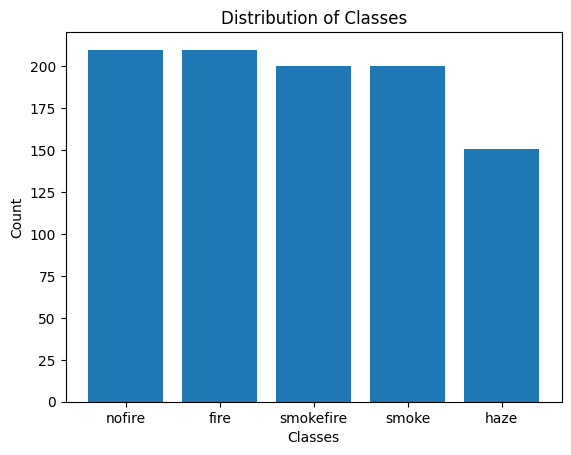

In [ ]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'test' DataFrame
test = create_dataframe(test_path)

# Now you can use 'test' in your code:
class_counts = test['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()




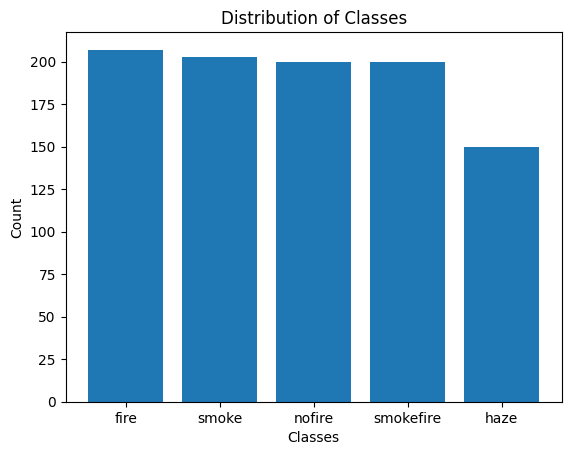

In [ ]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'test' DataFrame
val = create_dataframe(validation_path )

# Now you can use 'test' in your code:
class_counts = val['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

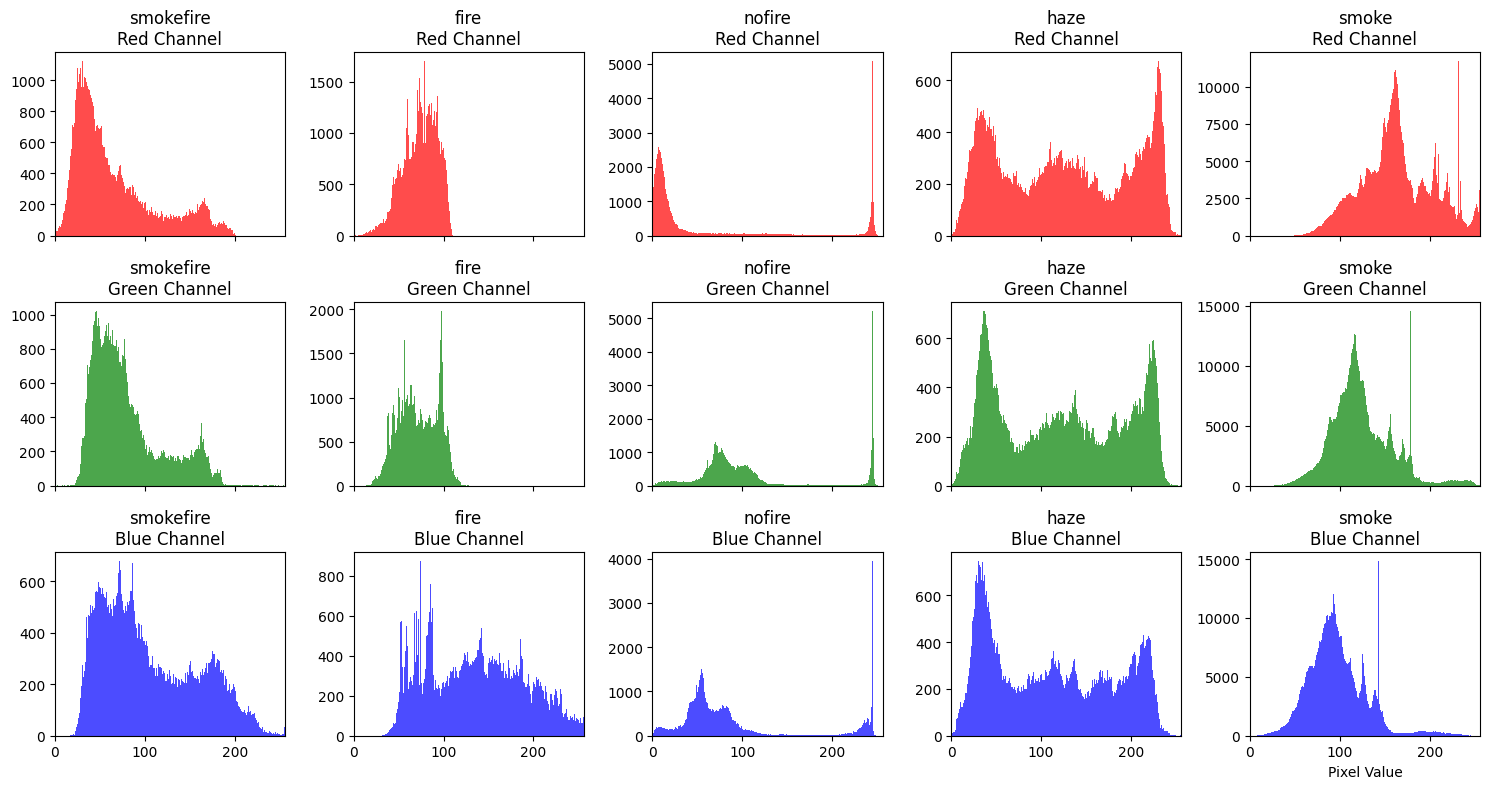

In [ ]:
import cv2

# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(train)


In this we are generating histograms for the Red, Green and Blue color channels for one sample image from each class in the dataset.

* fire images have high red intensity - Red channel can be used to detect fire.
* Smoke images have higher blue and green values - these can help separate smoke from fire.
* No fire images have balanced color distributions.
* Smokefire images mix red and blue/ green could help in detecting both elements together.

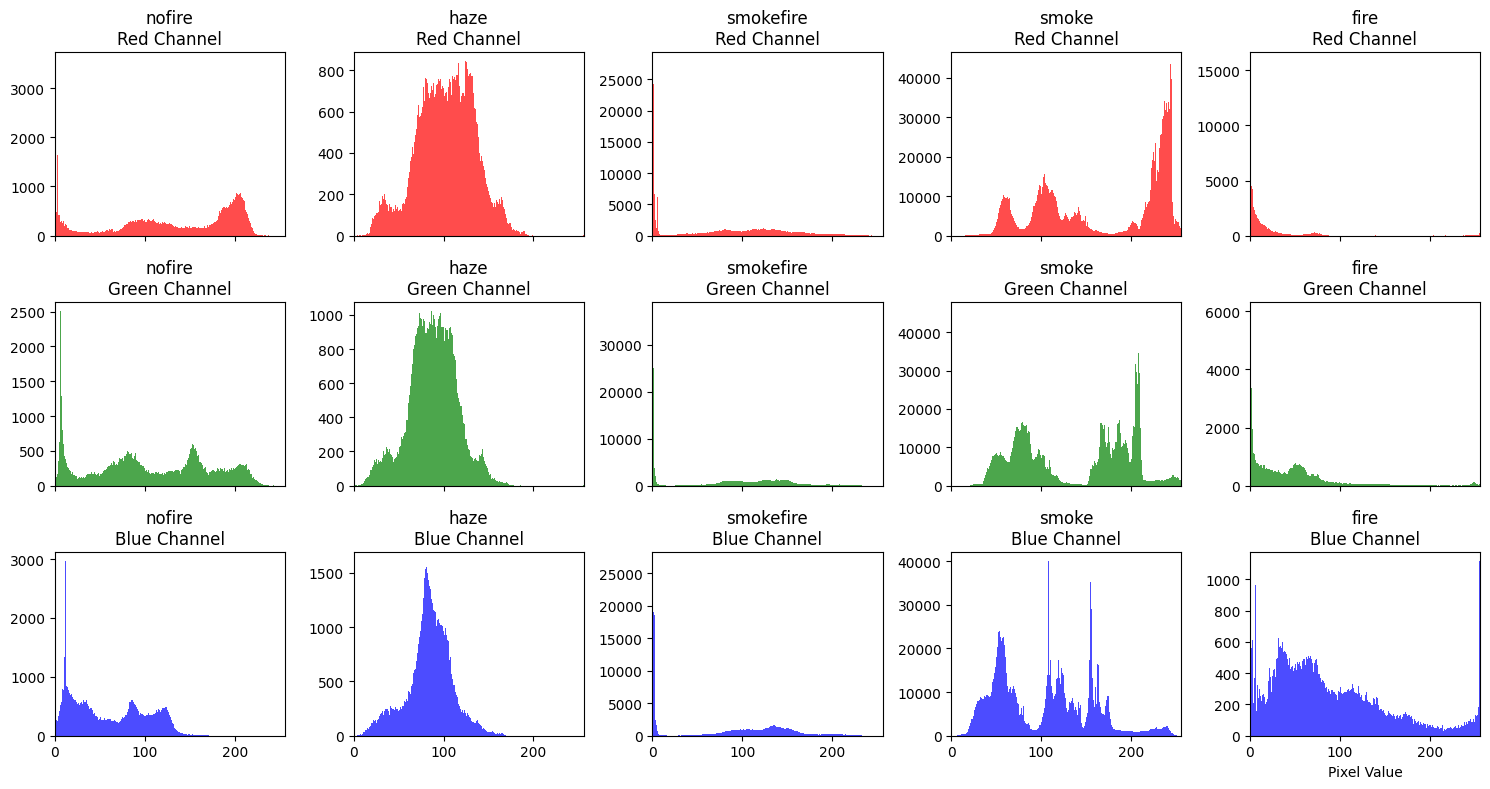

In [ ]:
# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(test)


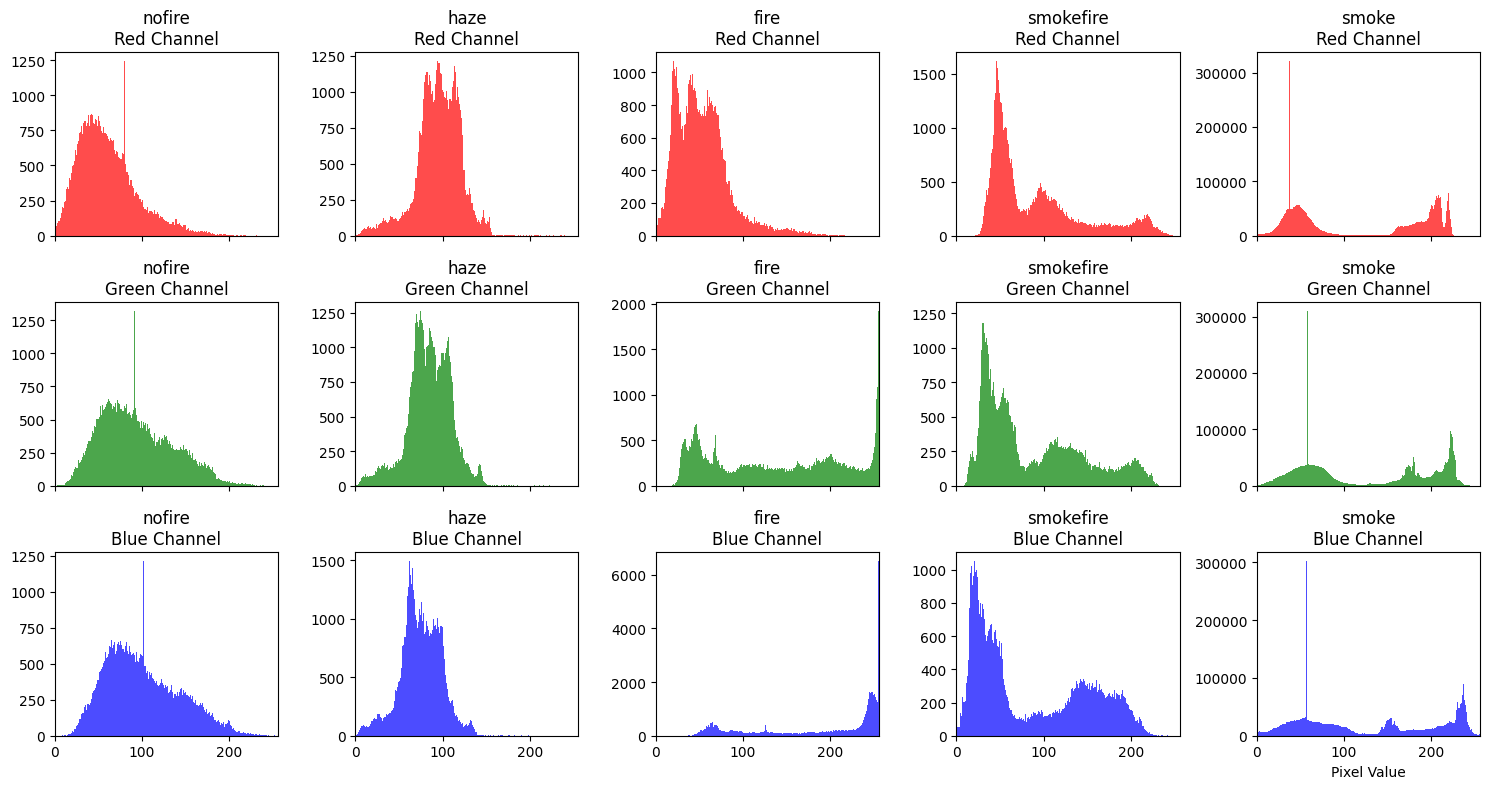

In [ ]:
# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(val)


Step 4: Display Sample Images


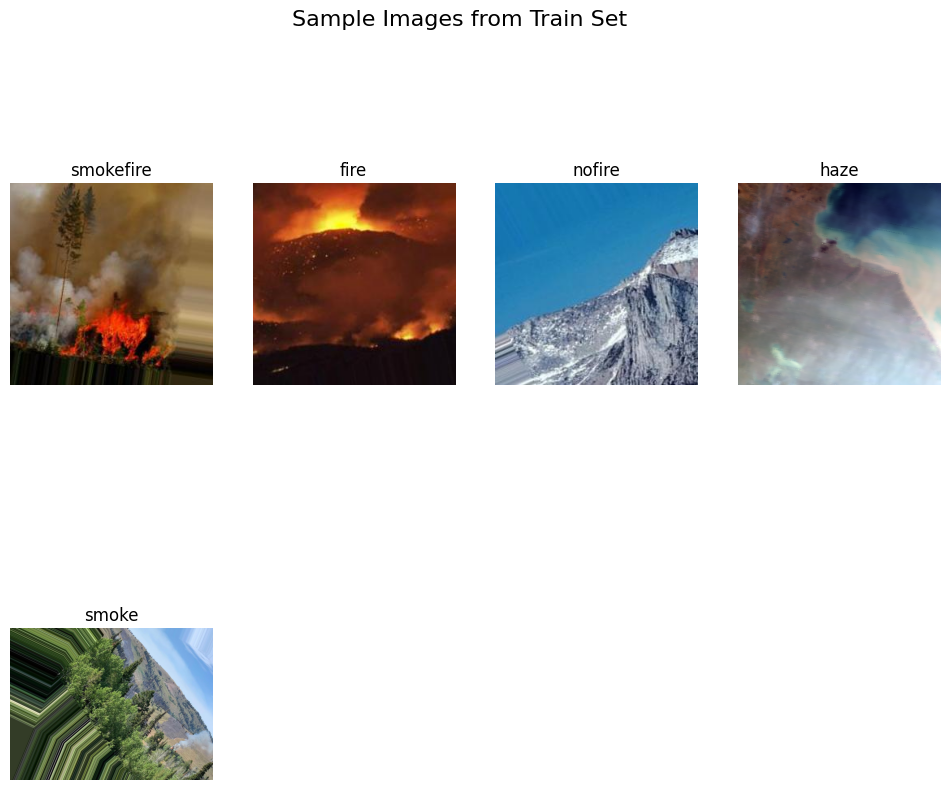

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import os

def display_images(dataset_path, title, num_cols=4):
    categories = os.listdir(dataset_path)
    categories = [c for c in categories if os.path.isdir(os.path.join(dataset_path, c))]  # Ensure only directories
    num_categories = len(categories)
    num_rows = (num_categories + num_cols - 1) // num_cols  # Calculate required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    fig.suptitle(title, fontsize=16)


    if num_rows == 1 or num_cols == 1:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else axes  # Flatten only if it's a NumPy array
    else:
        axes = axes.flatten()

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        img_name = random.choice(os.listdir(category_path))  # Pick a random image
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis("off")

    # Hide any unused subplot spaces
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused axes

    plt.show()

# Display images from the training set
display_images(train_path, "Sample Images from Train Set")

This is used to randomly display sample images from different categories in the dataset.

**Label Encoding**

In [ ]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
train['label_code'] = label_encoder.fit_transform(train['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'fire': np.int64(0), 'haze': np.int64(1), 'nofire': np.int64(2), 'smoke': np.int64(3), 'smokefire': np.int64(4)}


In this code encodes categorical labels into numberical values using label encoding.

In [ ]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
test['label_code'] = label_encoder.fit_transform(test['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'fire': np.int64(0), 'haze': np.int64(1), 'nofire': np.int64(2), 'smoke': np.int64(3), 'smokefire': np.int64(4)}


In [ ]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
val['label_code'] = label_encoder.fit_transform(val['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)


Label Mapping:
{'fire': np.int64(0), 'haze': np.int64(1), 'nofire': np.int64(2), 'smoke': np.int64(3), 'smokefire': np.int64(4)}


**Data Augmentation**


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  Data augmentation only for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#  No augmentation for validation and test sets (Only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

#  Load training images with augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load validation images (no augmentation)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

#  Load test images (no augmentation, no shuffling for evaluation)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3922 validated image filenames belonging to 5 classes.
Found 960 validated image filenames belonging to 5 classes.
Found 971 validated image filenames belonging to 5 classes.


In this train_datagen object is used to apply data agumentation to the training dataset.

* rescale=1./255 - It rescales pixel values to be between 0 and 1 by dividing each pixel value by 255. This helps normalize the image data.
* rotation_range=20 - It randomly rotates the image by up to 20 degrees.
* width_shift_range=0.2 - It randomly shifts the image horizontally by up to 20% of the total width.
* height_shift_range=0.2 - Randomly shifts the image vertically by up to 20% of the total height.
* shear_range =0.2 - It distorts by shifting the part of the image.
* zoom_range=0.2 - It zooms in randomly between 80% and 120% of the original image.
* horizontal_flip=True - Flips the image horizontally with a 50% chance.
* fill_mode = 'nearest' - using the nearest pixel value it determines how to fill in pixels taht are shifted outside of the image borders.

* val_test_datagen is used for the validation and test data. Unlike the training data no agumentation is applied here. the only transformation performed is rescaling to normalize the pixel values between 0 and 1.

* resized all images to 224x224 pixels as this is the standard size for CNNs and VGG16 and ResNet.

* as it is a multi classification problem the class mode is set as categorical, the labels will be one hot encoded.

Displaying images after augmentation and resizing


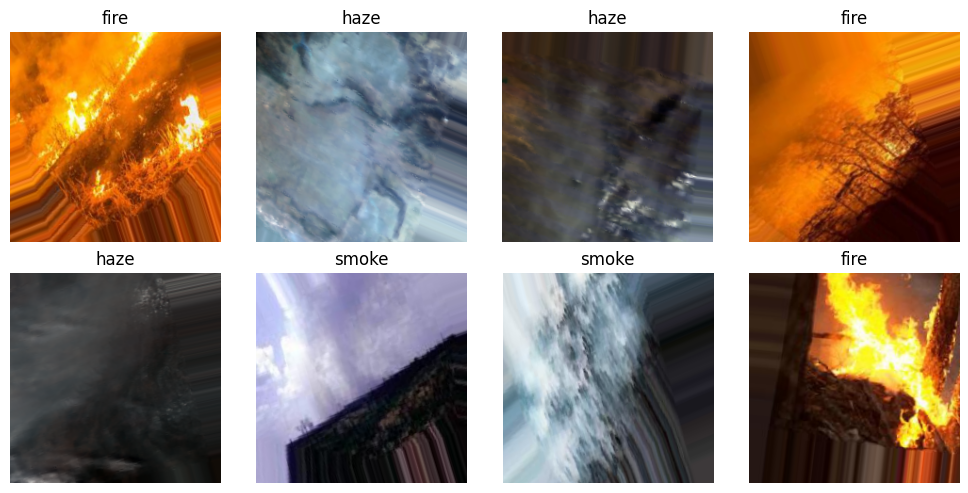

In [ ]:
img_batch,label_batch=next(train_generator)
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(10,5))
axes=axes.flatten()
for i in range(8):
  axes[i].imshow(img_batch[i])
  axes[i].axis('off')
  #axes[i].set_title(f"label:{label_batch[i]}")
  class_index=np.argmax(label_batch[i])
  class_name=train_generator.class_indices
  class_name=dict((v,k)for k,v in class_name.items())
  class_name=class_name[class_index]
  axes[i].set_title(f"{class_name}")
plt.tight_layout()
plt.show()

In this the code is designed to visualize a batch of images ( first 8 images) that are being passes through train_generator and display their corresponding class labels. It visually confirms that the images are being correctly loaded, augmented and labeled.

**Summarize Dataset Information**


In [ ]:

import pandas as pd # Import the pandas library and assign it the alias 'pd'

# Create a DataFrame summarizing dataset information
data_summary = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Total Images": [train_total, val_total, test_total],
    "Fire": [train_counts.get("fire", 0), val_counts.get("fire", 0), test_counts.get("fire", 0)],
    "No Fire": [train_counts.get("nofire", 0), val_counts.get("nofire", 0), test_counts.get("nofire", 0)],
    "Smoke": [train_counts.get("smoke", 0), val_counts.get("smoke", 0), test_counts.get("smoke", 0)],
    "Fire Smoke": [train_counts.get("smokefire", 0), val_counts.get("smokefire", 0), test_counts.get("smokefire", 0)],
    "Haze": [train_counts.get("haze", 0), val_counts.get("haze", 0), test_counts.get("haze", 0)]

})

#  Use display() to show the DataFrame in Colab
display(data_summary)


Dataset  Total Images  Fire  No Fire  Smoke  Fire Smoke  Haze
0       Train          3922   800      810    800         810   702
1  Validation           960   207      200    203         200   150
2        Test           971   210      210    200         200   151

All Datasets have a balanced distribution of images across the five classes . This shows that  how the data is distributed across three datasets ( training, testing and validation ).

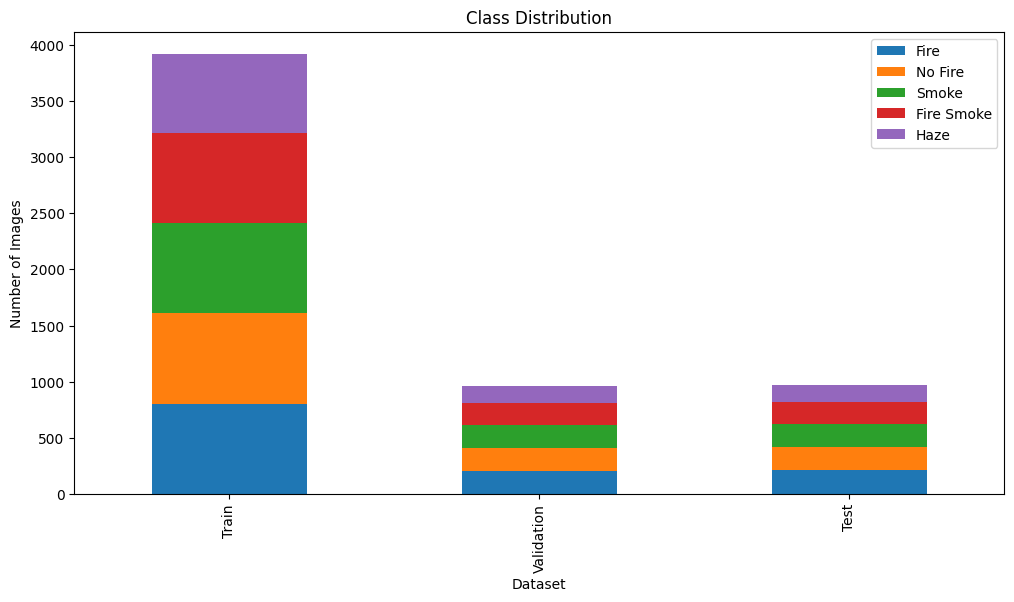

In [ ]:
def plot_class_distribution(data_summary):
  data_summary.set_index("Dataset",inplace=True)
  data_summary[['Fire','No Fire',"Smoke","Fire Smoke","Haze"]].plot(kind='bar',stacked=True,figsize=(12,6))
  plt.title("Class Distribution")
  plt.xlabel("Dataset")
  plt.ylabel("Number of Images")
  plt.legend(loc='upper right')
  plt.show()

plot_class_distribution(data_summary)

**Checking if all the images have the same size or not**


In [ ]:
def check_image_size(generator):
  sizes=set()
  for i in range(len(generator)):
    batch_x,batch_y=generator[i]
    for img in batch_x:
        sizes.add(img.shape[:2])
  return sizes

train_sizes=check_image_size(train_generator)
val_sizes=check_image_size(val_generator)
test_sizes=check_image_size(test_generator)
print(f"Train Image Sizes: {train_sizes}")
print(f"Validation Image Sizes: {val_sizes}")
print(f"Test Image Sizes: { test_sizes}")
if len(train_sizes)>1 or len(val_sizes)>1 or len(test_sizes)>1:
  print("All images are not having the same size")
else:
  print("All images are having the same size")

Train Image Sizes: {(224, 224)}
Validation Image Sizes: {(224, 224)}
Test Image Sizes: {(224, 224)}
All images are having the same size



All images in the dataset have the same size of 224 × 224 pixels.

This consistency ensures compatibility with deep learning models like VGG16 and Xception, which require fixed-size input.



**VGG16**


Loading the VGG16 model pre-trained on ImageNet, without the top classification layers.

include_top=False: allows us to add a custom classification head

input_shape=(224, 224, 3): matches the size of our input images

All base layers of VGG16 are frozen, so only the top layers are trainable — a common approach when working with smaller datasets.

A Dropout layer is added to reduce overfitting by randomly turning off 50% of neurons during training.

Since we are working with 5 classes, the final Dense layer has 5 output units with softmax activation.

In [ ]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.trainable=False
model=models.Sequential([base_model,
                         layers.GlobalAveragePooling2D(),
                         layers.Dense(128,activation='relu'),
                         layers.Dropout(0.5),
                         layers.Dense(5,activation='softmax')])

We are using Adam optimizer for adaptive learning.

Categorical crossentropy is used as the loss function as we are having multi classes.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Training the model for 10 epochs.

In [ ]:
history=model.fit(train_generator,validation_data=val_generator,epochs=10)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.3418 - loss: 1.5068

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 97s 669ms/step - accuracy: 0.3425 - loss: 1.5055 - val_accuracy: 0.6844 - val_loss: 1.0031
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 77s 630ms/step - accuracy: 0.5921 - loss: 1.0732 - val_accuracy: 0.7531 - val_loss: 0.7836
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 77s 590ms/step - accuracy: 0.6436 - loss: 0.9306 - val_accuracy: 0.7615 - val_loss: 0.6701
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 584ms/step - accuracy: 0.6820 - loss: 0.8322 - val_accuracy: 0.8073 - val_loss: 0.5929
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 583ms/step - accuracy: 0.6900 - loss: 0.7859 - val_accuracy: 0.7854 - val_loss: 0.5736
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 595ms/step - accuracy: 0.7298 - loss: 0.7222 - val_accuracy: 0.7844 - val_loss: 0.5516
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 594ms/step - accuracy: 0.7283 - loss: 0.6791 - val_accuracy: 0.8115 - val_loss: 0.5158
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 586ms/step - accuracy: 0.7471 - loss: 0.6660 - val

Plotting the graphs how training and validation metrics evolve over epochs.

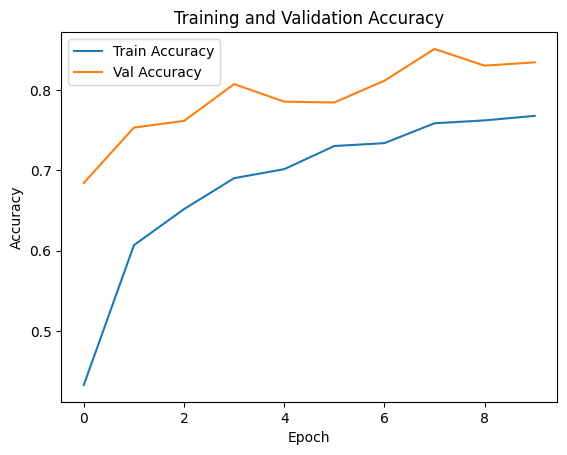

In [ ]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

From the accuracy plot, we can see that:

Training accuracy improves steadily over time

Validation accuracy remains slightly higher than training accuracy, which is a good sign and suggests good generalization



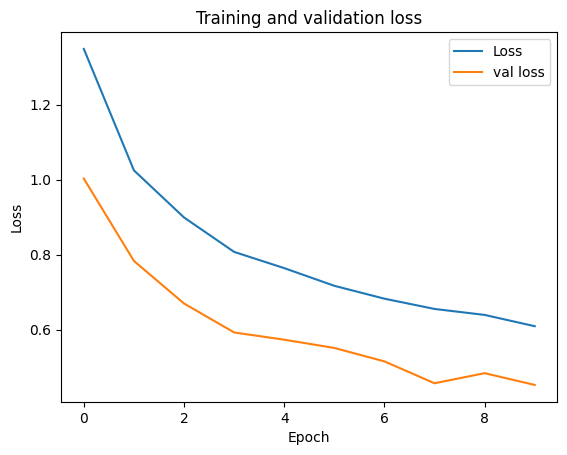

In [ ]:
plt.plot(history.history["loss"],label='Loss')
plt.plot(history.history["val_loss"],label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

from this graph we can see that the losses go down showing that the model is learning effectively.

val loss is lower than the training loss suggests that good generalization.

In [ ]:
y_pred=model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=test_generator.classes
class_labels=list(test_generator.class_indices.keys())
print(classification_report(y_true,y_pred_classes,target_names=class_labels))

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step
              precision    recall  f1-score   support

        fire       0.87      0.68      0.76       210
        haze       0.90      0.99      0.94       151
      nofire       0.90      0.95      0.93       210
       smoke       0.48      0.92      0.63       200
   smokefire       0.21      0.04      0.07       200

    accuracy                           0.70       971
   macro avg       0.67      0.72      0.67       971
weighted avg       0.67      0.70      0.66       971



From the classification report Fire class is detected well when predicted as it has high precision value, But many true fire samples are missed as Recall is low.

Nofire class is performing well as its Precision and Recall is greater than 0.9

Smoke shows high recall but low precision. Model detects many smoke instances but many are false positives.

SmokeFire is severly underperforming -it can be due to confusion with smoke or fire classes and possibly with overlap.

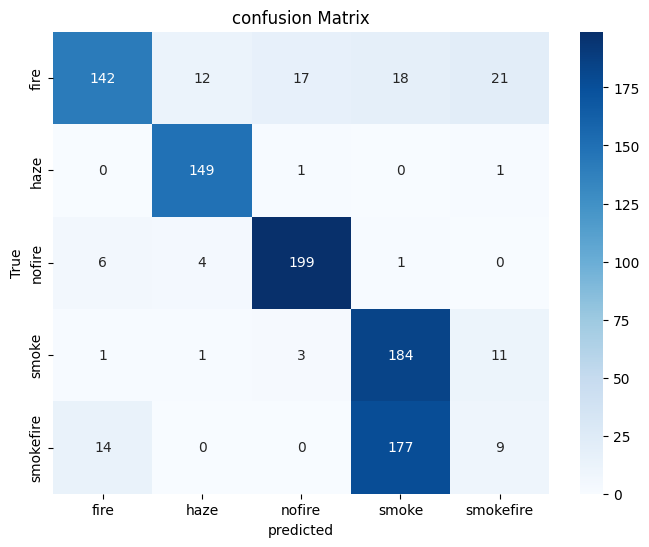

In [ ]:
cm=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel("predicted")
plt.ylabel("True")
plt.title("confusion Matrix")
plt.show()

In [ ]:
x_test,y_test=next(test_generator)
class_indices=test_generator.class_indices
idx_to_label=dict((v,k)for k,v in class_indices.items())


In [ ]:
preds=model.predict(x_test)
pred_classes=np.argmax(preds,axis=1)
true_classes=np.argmax(y_test,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


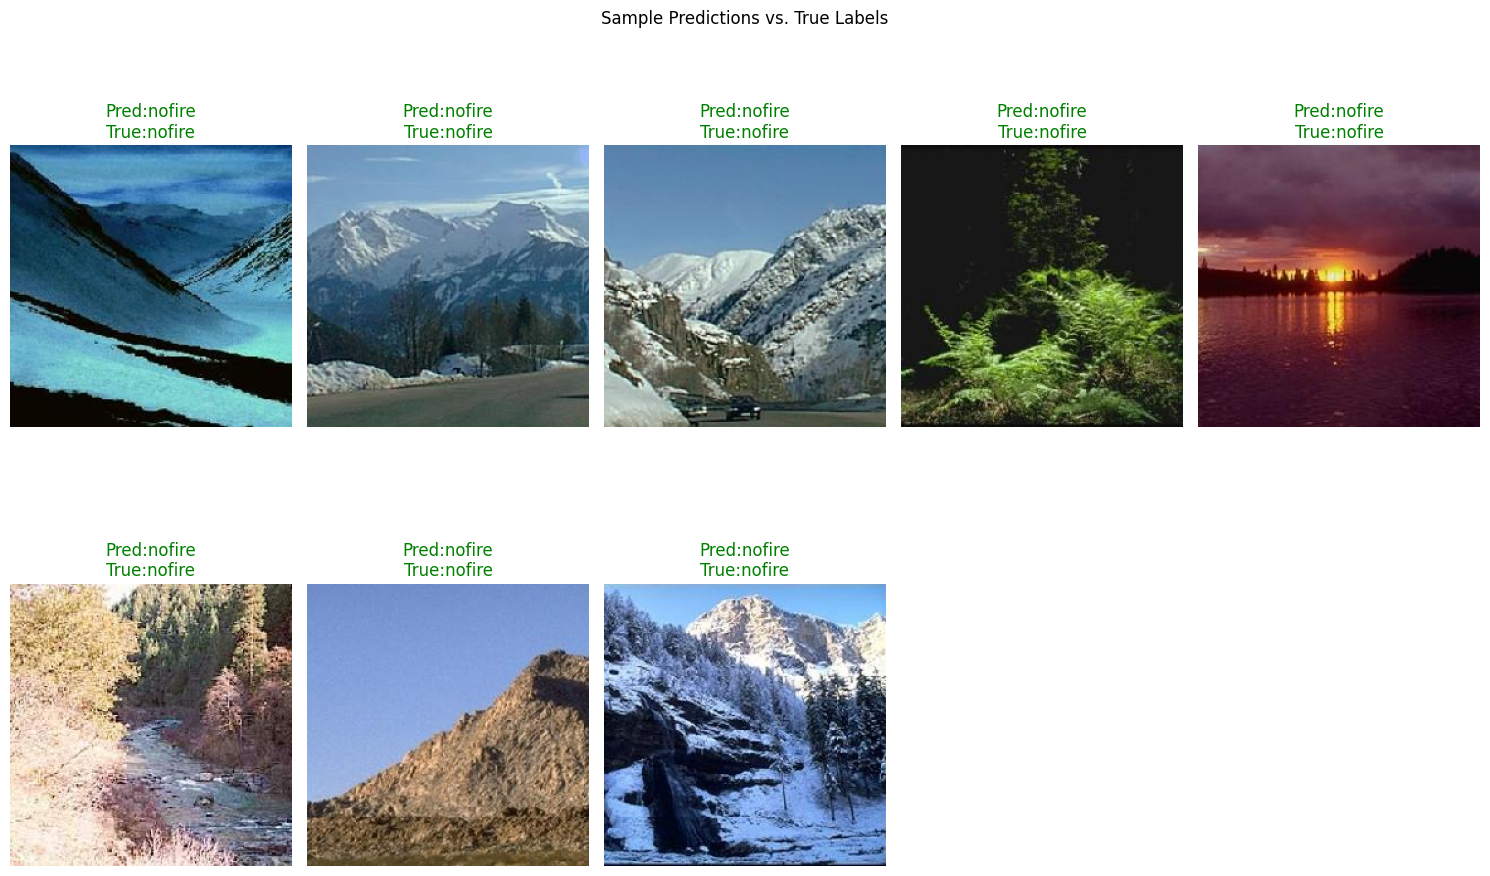

In [ ]:
plt.figure(figsize=(15,10))
for i in range(8):
  plt.subplot(2,5,i+1)
  plt.imshow(x_test[i])
  plt.axis("off")
  true_label=idx_to_label[true_classes[i]]
  pred_label=idx_to_label[pred_classes[i]]
  color="green" if true_label==pred_label else 'red'
  plt.title(f"Pred:{pred_label}\nTrue:{true_label}",color=color)
plt.suptitle("Sample Predictions vs. True Labels")
plt.tight_layout()
plt.show()

Here we can see that the Green title shows correct prediction and red shows the wrong prediction.

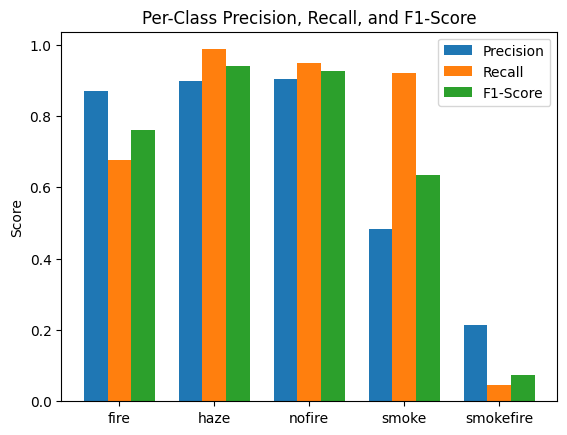

In [ ]:
# Calculate class-wise metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Bar chart
x = np.arange(len(class_labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')
plt.xticks(x, class_labels)
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1-Score')
plt.legend()
plt.show()


🔥 Fire:
High precision, but lower recall — the model correctly identifies fire when it predicts fire, but misses many actual fire instances.
➤ It plays it safe when predicting fire.

🌫️ Haze:
Excellent performance with both precision and recall near 0.99 — the model almost always predicts haze correctly and rarely confuses it with other classes.
 Very strong and reliable class prediction.

🌲 Nofire:
Also performed very well, with both precision and recall above 0.9.
 Strong model confidence and low confusion with other classes.

💨 Smoke:
High recall but low precision — the model detects almost all smoke images, but it also mistakenly labels non-smoke images as smoke.
 Tends to overpredict smoke.

🔥💨 Smokefire:
Poor performance — the model confuses this class frequently with either smoke or fire.
 Likely due to visual overlap and limited distinction in features.



**Xception**

Loading the pretrained Xception model without the top classification layers.

In [ ]:
xception_base=Xception(weights='imagenet',include_top=False,input_shape=(224,224,3))
xception_base.trainable=False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_xcep=models.Sequential([xception_base,
                              layers.GlobalAveragePooling2D(),
                              layers.Dense(128,activation='relu'),
                              layers.Dropout(0.5),
                              layers.Dense(5,activation='softmax')])

In [ ]:
model_xcep.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
history_xcep=model_xcep.fit(train_generator,
                            validation_data=val_generator,
                            epochs=10)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 94s 654ms/step - accuracy: 0.6129 - loss: 0.9575 - val_accuracy: 0.7990 - val_loss: 0.4829
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 96s 784ms/step - accuracy: 0.8131 - loss: 0.5065 - val_accuracy: 0.8708 - val_loss: 0.3326
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 585ms/step - accuracy: 0.8343 - loss: 0.4385 - val_accuracy: 0.8604 - val_loss: 0.3414
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 71s 575ms/step - accuracy: 0.8451 - loss: 0.3995 - val_accuracy: 0.8667 - val_loss: 0.3268
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 587ms/step - accuracy: 0.8515 - loss: 0.3787 - val_accuracy: 0.8802 - val_loss: 0.3238
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 77s 622ms/step - accuracy: 0.8593 - loss: 0.3639 - val_accuracy: 0.8833 - val_loss: 0.3018
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 591ms/step - accuracy: 0.8557 - loss: 0.3595 - val_accuracy: 0.8865 - val_loss: 0.2781
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 580ms/step - accuracy: 0.8638 - loss: 0

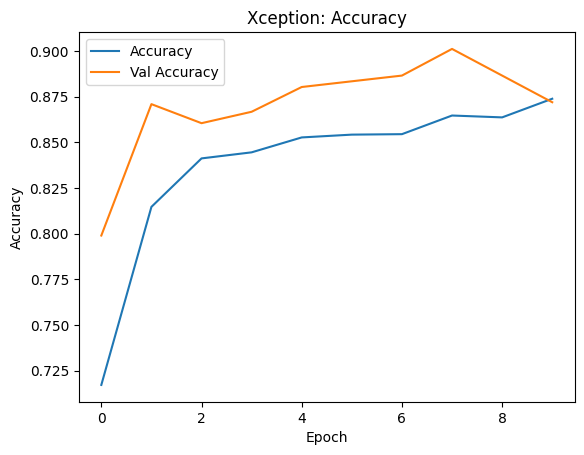

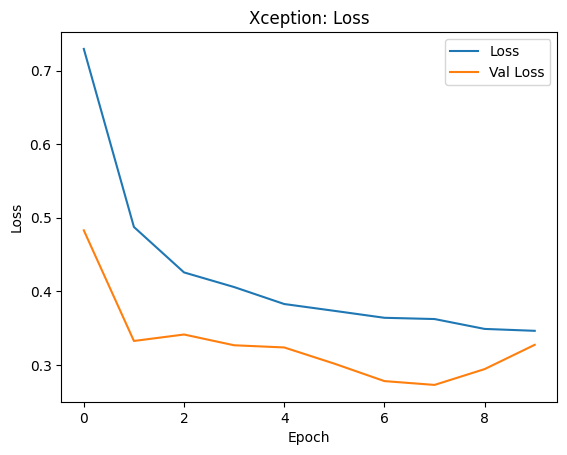

In [ ]:
plt.plot(history_xcep.history['accuracy'], label='Accuracy')
plt.plot(history_xcep.history['val_accuracy'], label='Val Accuracy')
plt.title("Xception: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_xcep.history['loss'], label='Loss')
plt.plot(history_xcep.history['val_loss'], label='Val Loss')
plt.title("Xception: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy Plot :

From the graphs we can see that the training accuracy starts around 70% ends around 86% and validation accuracy starts at around 83% and peaks at 88%.

* model generalizes well.
* validation accuracy remains above training accuracy shows no overfitting and suggests to fine tune by unfreeze layers.

Loss Plot:

Both training and validation loss consistently decrease. for validation the loss ends at 0.32 and for training the loss ends at 0.34.

* shows good convergence.
* No major overfitting.


In [ ]:
y_pred_xcep = model_xcep.predict(test_generator)
y_pred_classes_xcep = np.argmax(y_pred_xcep, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step


In [ ]:
# Classification Report
print(classification_report(y_true, y_pred_classes_xcep, target_names=class_labels))



              precision    recall  f1-score   support

        fire       0.90      0.65      0.76       210
        haze       0.99      0.99      0.99       151
      nofire       0.87      0.96      0.92       210
       smoke       0.56      0.91      0.69       200
   smokefire       0.38      0.23      0.28       200

    accuracy                           0.74       971
   macro avg       0.74      0.75      0.73       971
weighted avg       0.73      0.74      0.72       971





🔥 Fire:

High Precision: 0.88 — when it predicts fire, it's usually correct.

Low Recall: 0.59 — misses many real fire images (often predicts smoke or smokefire).

🚫 Nofire:

Excellent performance across all metrics — the model finds this class easiest to detect.

💨 Smoke:

Low precision: 0.49 — often mislabels other images as smoke

High recall: 0.93 — catches most smoke images but at the cost of false positives.

🔥💨 Smokefire:

Weak performance — confused with both smoke and fire due to visual overlap.

🌫️ Haze:

Near-perfect performance (precision & recall ~0.99)

Rarely misclassified, very confidently predicted



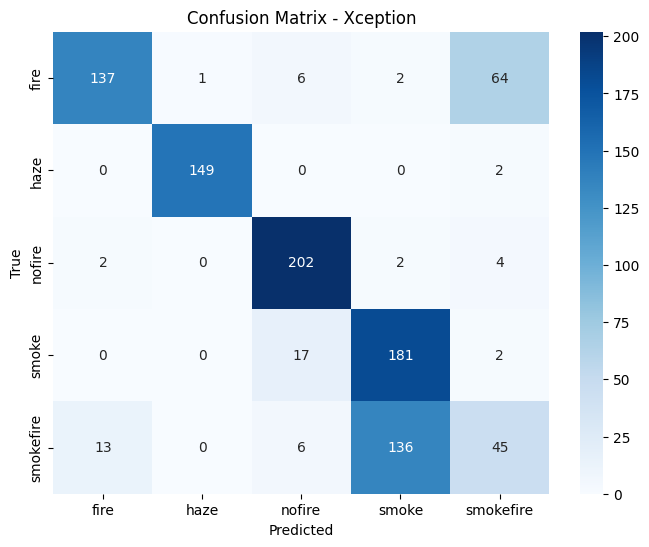

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes_xcep)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Xception")
plt.show()

In [ ]:
# Load one batch from the test generator
x_test_batch, y_test_batch = next(test_generator)

# Get class label mapping
class_indices = test_generator.class_indices
idx_to_label = dict((v, k) for k, v in class_indices.items())

# Get predictions
preds = model_xcep.predict(x_test_batch)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_test_batch, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


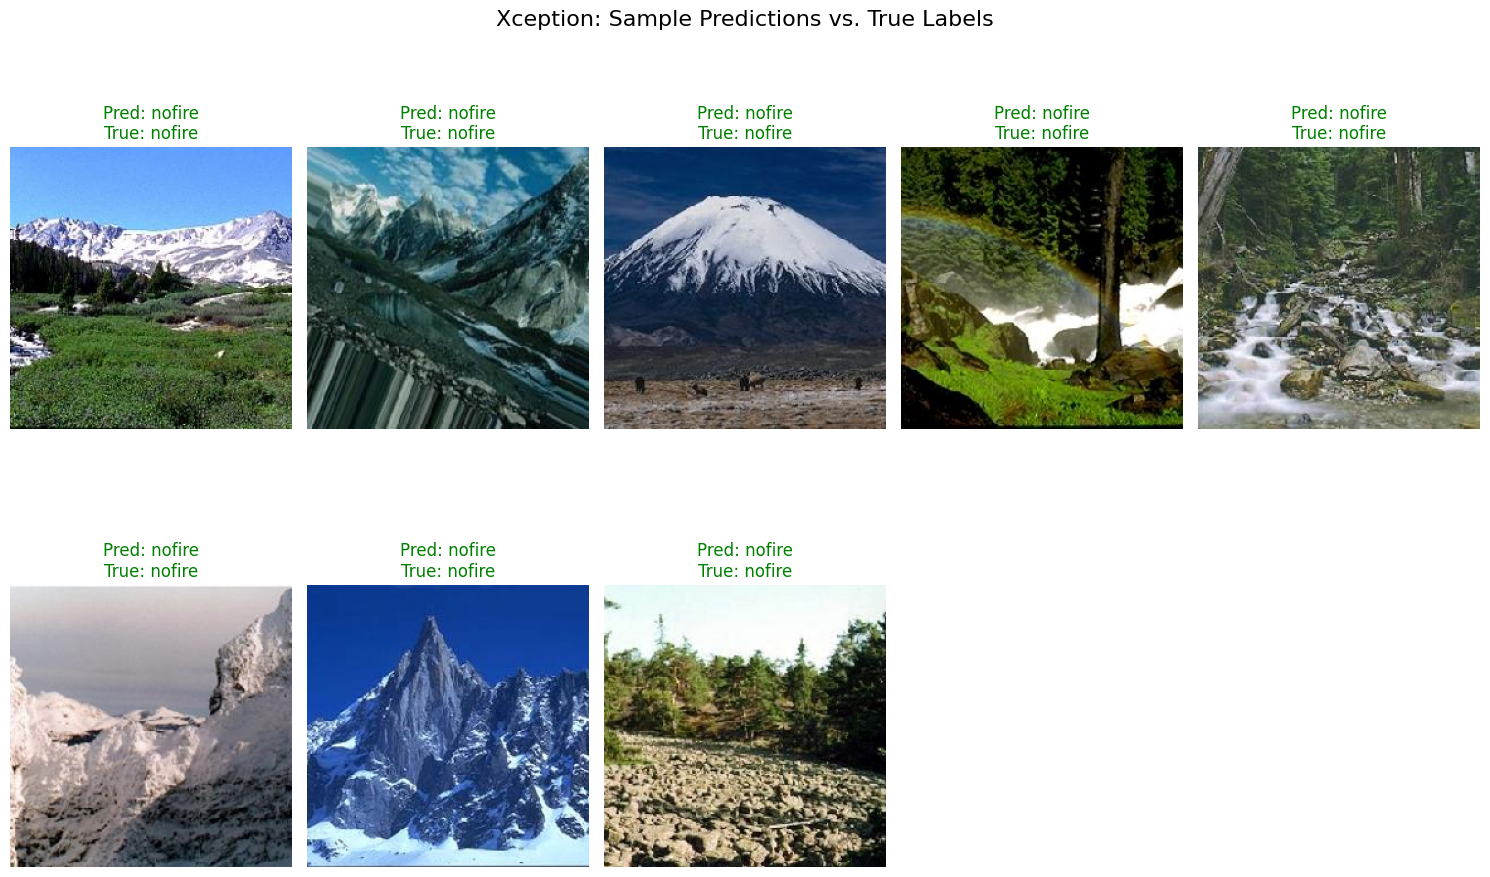

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_batch[i])
    plt.axis("off")
    true_label = idx_to_label[true_classes[i]]
    pred_label = idx_to_label[pred_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
plt.suptitle("Xception: Sample Predictions vs. True Labels", fontsize=16)
plt.tight_layout()
plt.show()


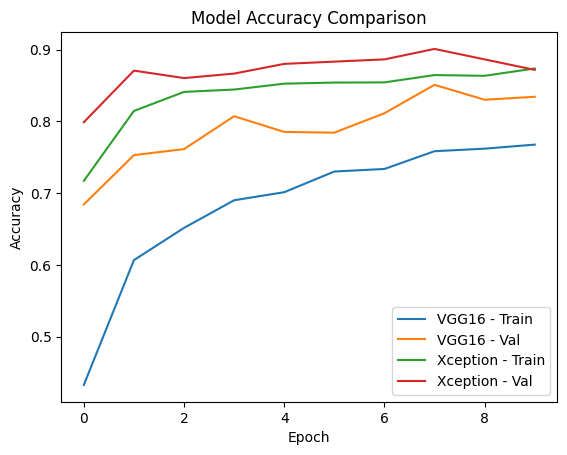

In [ ]:
plt.plot(history.history['accuracy'], label='VGG16 - Train')
plt.plot(history.history['val_accuracy'], label='VGG16 - Val')
plt.plot(history_xcep.history['accuracy'], label='Xception - Train')
plt.plot(history_xcep.history['val_accuracy'], label='Xception - Val')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Xception is the better model overall.

Validation accuracy is consistently high suggesting Xception generalizes well.

VGG16 underfits slightly especially in early epochs and converges slowly.

No major overfitting in either model, which shows that the data augmentation is working well.

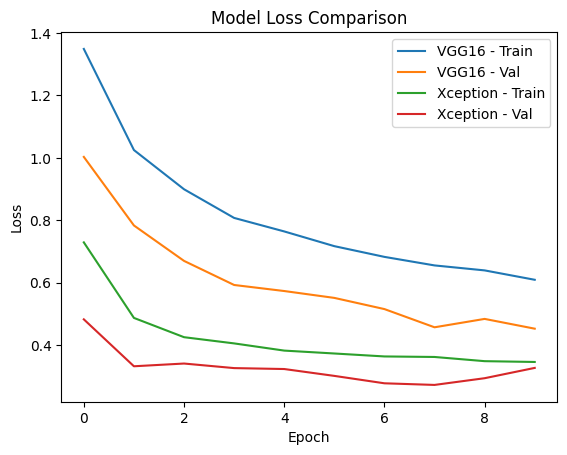

In [ ]:
plt.plot(history.history['loss'], label='VGG16 - Train')
plt.plot(history.history['val_loss'], label='VGG16 - Val')
plt.plot(history_xcep.history['loss'], label='Xception - Train')
plt.plot(history_xcep.history['val_loss'], label='Xception - Val')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**VGG16**

* Starts with a veru high training loss (1.22) and decreases steadily to 0.61.
* Validation loss also drop from 0.93 to 0.46.
* This shows slow but stable learning.
* Final gap between train and val loss is moderate, indicating some room for improvement.

**Xception**

* Starts with much lower loss 0.70 for train and 0.45 for validation.
* Drops faster and stabilizes between 0.31 to 0.35 on both train and validation.
* No significant overfitting - validation loss closely tracks training loss.
* Final loss is clearly lower than VGG16, which means better predictive performance.


Xception converges faster and to a lower loss.

Indicates better feature extraction , fewer misclassifiations and more confident preddictions.

Very little overfitting in both models due to good augmentation and early stopping.


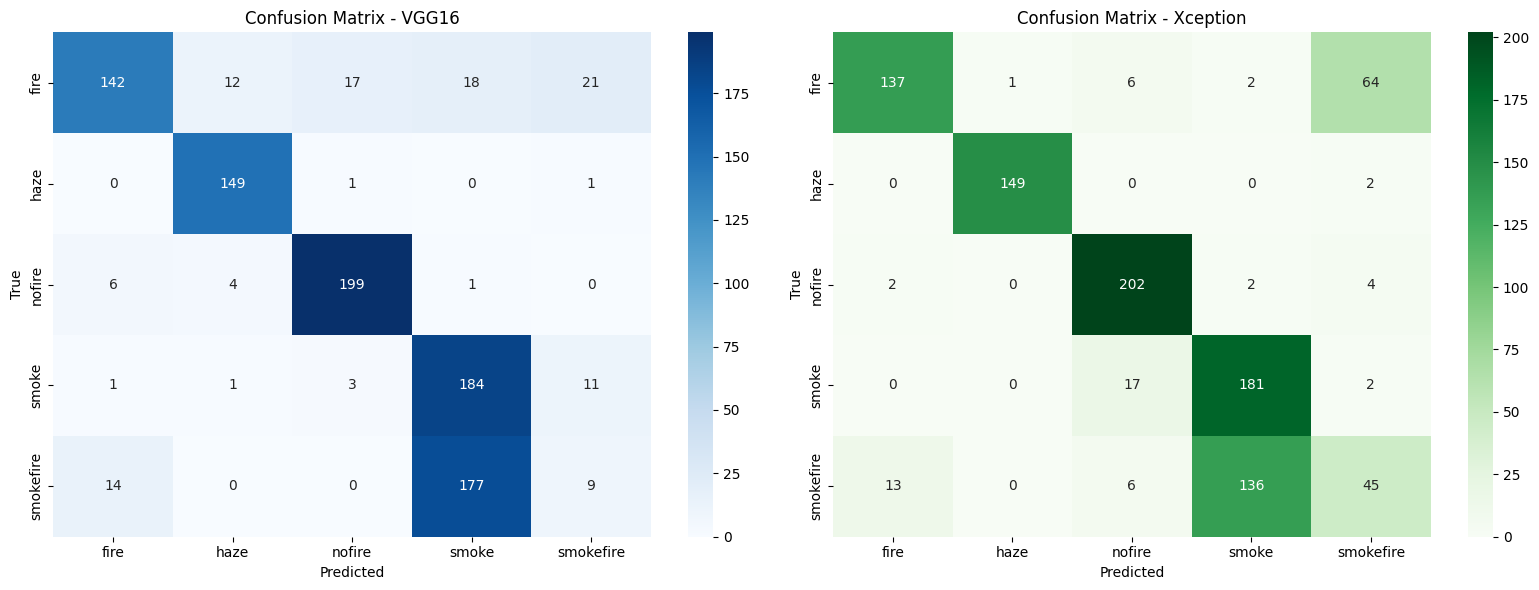

In [ ]:
cm_vgg = confusion_matrix(y_true, y_pred_classes)
cm_xcep = confusion_matrix(y_true, y_pred_classes_xcep)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VGG16
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_title("Confusion Matrix - VGG16")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Xception
sns.heatmap(cm_xcep, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_title("Confusion Matrix - Xception")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get reports as dictionaries
report_vgg = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
report_xcep = classification_report(y_true, y_pred_classes_xcep, target_names=class_labels, output_dict=True)

# Extract macro averages
vgg_macro = report_vgg['macro avg']
xcep_macro = report_xcep['macro avg']

# Print nicely
print("VGG16 - Macro Avg:")
print(f"Precision: {vgg_macro['precision']:.4f}")
print(f"Recall:    {vgg_macro['recall']:.4f}")
print(f"F1-score:  {vgg_macro['f1-score']:.4f}")

print("\n Xception - Macro Avg:")
print(f"Precision: {xcep_macro['precision']:.4f}")
print(f"Recall:    {xcep_macro['recall']:.4f}")
print(f"F1-score:  {xcep_macro['f1-score']:.4f}")


VGG16 - Macro Avg:
Precision: 0.6744
Recall:    0.7151
F1-score:  0.6672

 Xception - Macro Avg:
Precision: 0.7435
Recall:    0.7462
F1-score:  0.7284


Here I am taking the macro average means calculating the metric independently for each class then taking the average, it treats all classes equally, regardless of the number of instances.

From all the metrics like precision , Recall and F1-score Xception model looks better than VGG16.

Initially we trained the xception model with feature extraction only by keeping xception_base.trainable=False.

Now we are unfreezing the last 30 layers of Xception allowing them to retrain and adapt to the dataset.

This is called partial fine tuning, which is a common strategy  when the dataset is relatively small and want to preserve the benefits of pretraining while specializing a portion of the network.

In [ ]:
# Unfreeze the last 30 layers
xception_base.trainable = True
for layer in xception_base.layers[:-30]:
    layer.trainable = False


Lower learning rate ensures stable and gradual updates to the pretrained weights during fine tuning.

In [ ]:
# Recompile the model with a low learning rate
model_xcep.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Early stopping : Stops training if validation accuracy stops improving.( patience - 3epochs)

ModelCheckpoint: Saves only the best model during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_xception_finetuned.h5", save_best_only=True)
]

The model is now trained further, but only the last 30 layers of Xception and the classification head are updated.

In [ ]:
# Fine-tune the model
history_ft = model_xcep.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6504 - loss: 0.9284

123/123 ━━━━━━━━━━━━━━━━━━━━ 106s 714ms/step - accuracy: 0.6509 - loss: 0.9272 - val_accuracy: 0.8510 - val_loss: 0.3980
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7955 - loss: 0.5404

123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 585ms/step - accuracy: 0.7956 - loss: 0.5400 - val_accuracy: 0.8844 - val_loss: 0.3145
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.8556 - loss: 0.4109

123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 591ms/step - accuracy: 0.8557 - loss: 0.4107 - val_accuracy: 0.8927 - val_loss: 0.2873
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8725 - loss: 0.3602

123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 593ms/step - accuracy: 0.8725 - loss: 0.3601 - val_accuracy: 0.8948 - val_loss: 0.2738
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8801 - loss: 0.3170

123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 589ms/step - accuracy: 0.8801 - loss: 0.3170 - val_accuracy: 0.9031 - val_loss: 0.2574
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.8826 - loss: 0.3044

123/123 ━━━━━━━━━━━━━━━━━━━━ 72s 582ms/step - accuracy: 0.8827 - loss: 0.3043 - val_accuracy: 0.9000 - val_loss: 0.2521
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8894 - loss: 0.2974

123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 592ms/step - accuracy: 0.8894 - loss: 0.2973 - val_accuracy: 0.9115 - val_loss: 0.2310
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9115 - loss: 0.2511

123/123 ━━━━━━━━━━━━━━━━━━━━ 78s 635ms/step - accuracy: 0.9114 - loss: 0.2512 - val_accuracy: 0.9115 - val_loss: 0.2266
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9087 - loss: 0.2511

123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 644ms/step - accuracy: 0.9088 - loss: 0.2510 - val_accuracy: 0.9135 - val_loss: 0.2100
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9172 - loss: 0.2185

123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 636ms/step - accuracy: 0.9172 - loss: 0.2185 - val_accuracy: 0.9219 - val_loss: 0.1976


In [ ]:
# Predict on test data
y_pred_ft = model_xcep.predict(test_generator)
y_pred_classes_ft = np.argmax(y_pred_ft, axis=1)
y_true_ft = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step


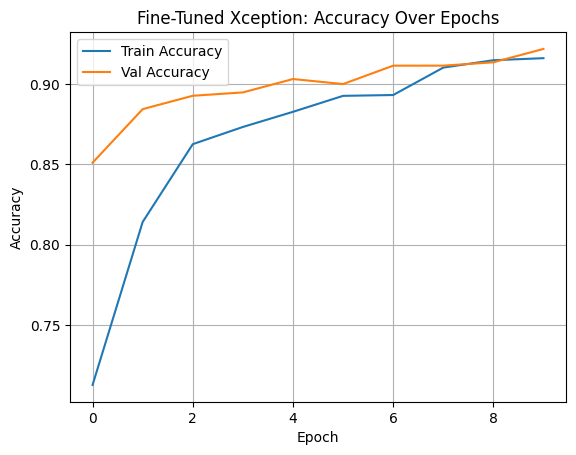

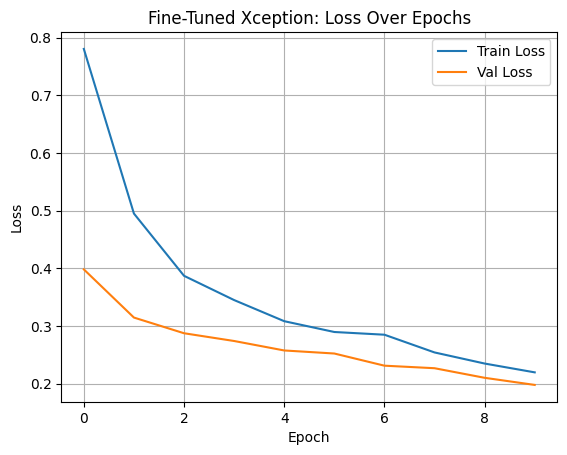

In [ ]:
# Plot Accuracy
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Val Accuracy')
plt.title('Fine-Tuned Xception: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuned Xception: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

These two plots are showing how the fine tuned Xception model performed over 10 epochs in terms of accuracy and loss.

Accuracy Plot:
* Training accuracy starts around 69% and increased steadily to 91%.
* validation accuracy starts high at 83% improves gradually, and finishes slightly above 91%.
* Both curves improves consistently with no signs of overfitting.
* The validation accuracy is consistently higher than the training accuracy shows a very good sign showing strong generalization and effective transfer learning and fine tuning.
* Early stopping might have helped in stabilize learning.

Loss plot:
* Training loss starts high at 0.8 drops sharply, and ends around 0.24.
* validation loss starts lower at 0.44 and decreases staedily to 0.23.
* Both training and validation loss decrease consistently indicating good conevrgence.




In [ ]:

print("Classification Report - Fine-Tuned Xception")
print(classification_report(y_true_ft, y_pred_classes_ft, target_names=class_labels))

Classification Report - Fine-Tuned Xception
              precision    recall  f1-score   support

        fire       0.94      0.71      0.81       210
        haze       0.99      0.99      0.99       151
      nofire       0.96      0.98      0.97       210
       smoke       0.60      0.95      0.74       200
   smokefire       0.52      0.34      0.41       200

    accuracy                           0.78       971
   macro avg       0.80      0.79      0.78       971
weighted avg       0.80      0.78      0.77       971



Overall accuracy : accuracy is improved from 73% to 75%. after fine tuning.



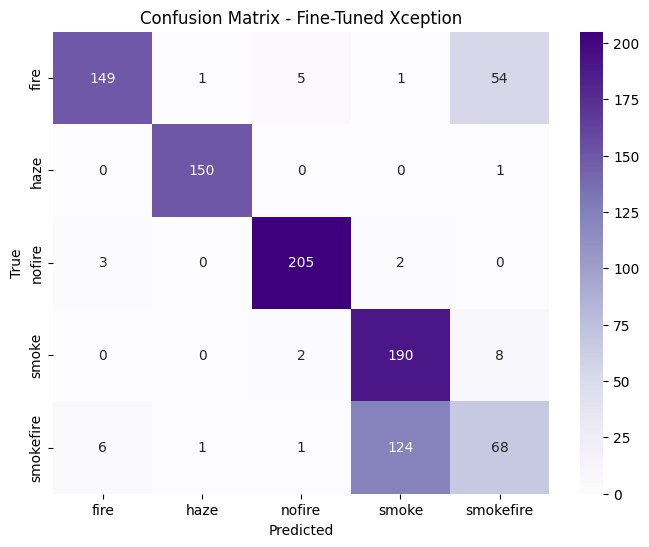

In [ ]:
cm_ft = confusion_matrix(y_true_ft, y_pred_classes_ft)

plt.figure(figsize=(8,6))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fine-Tuned Xception")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


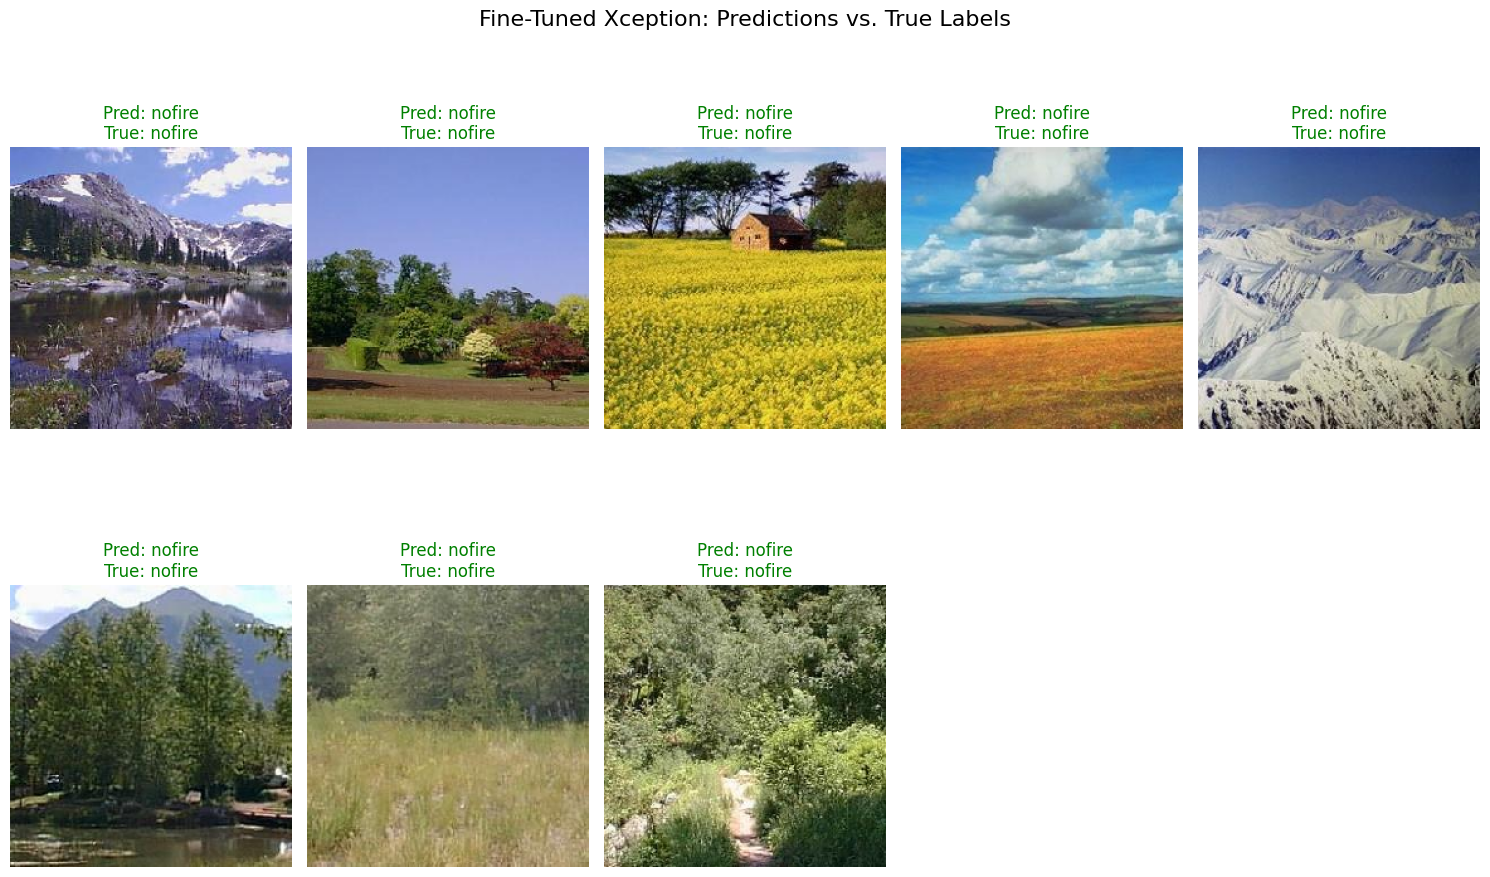

In [ ]:
# Load a batch
x_test_batch_ft, y_test_batch_ft = next(test_generator)

# Convert predictions
preds_ft = model_xcep.predict(x_test_batch_ft)
pred_classes_ft = np.argmax(preds_ft, axis=1)
true_classes_ft = np.argmax(y_test_batch_ft, axis=1)
idx_to_label = {v: k for k, v in test_generator.class_indices.items()}

# Plot
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_batch_ft[i])
    plt.axis("off")
    true_label = idx_to_label[true_classes_ft[i]]
    pred_label = idx_to_label[pred_classes_ft[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
plt.suptitle("Fine-Tuned Xception: Predictions vs. True Labels", fontsize=16)
plt.tight_layout()
plt.show()

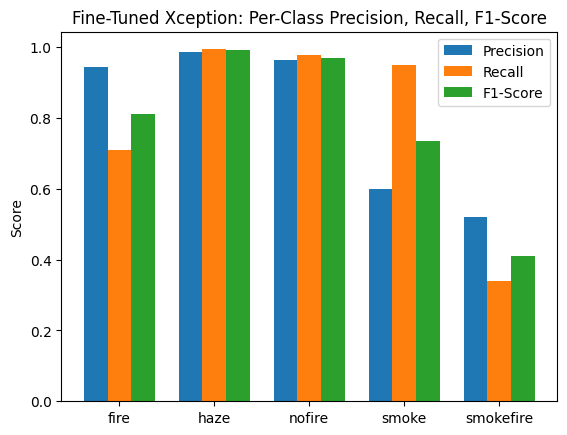

In [ ]:
precision_ft = precision_score(y_true_ft, y_pred_classes_ft, average=None)
recall_ft = recall_score(y_true_ft, y_pred_classes_ft, average=None)
f1_ft = f1_score(y_true_ft, y_pred_classes_ft, average=None)

x = np.arange(len(class_labels))
width = 0.25

plt.bar(x - width, precision_ft, width, label='Precision')
plt.bar(x, recall_ft, width, label='Recall')
plt.bar(x + width, f1_ft, width, label='F1-Score')
plt.xticks(x, class_labels)
plt.ylabel('Score')
plt.title('Fine-Tuned Xception: Per-Class Precision, Recall, F1-Score')
plt.legend()
plt.show()

This bar plot shows per class precision, recall and f1 score. for the fine tuned Xception model.

Model
🔥 Fire

Precision: 0.92 → When it predicts fire, it's usually correct.

Recall: 0.70 → Misses about 30% of actual fire cases.

F1-score: 0.79

📌 Insight: The model is careful when predicting fire, but accurate when it does.

🌫️ Haze

Precision: 0.99

Recall: 0.99

F1-score: 0.99

🌟 Insight: The best-performing class. The model predicts haze almost perfectly, with virtually no confusion.

🌲 Nofire

Precision, Recall, F1-score: All ~0.98

💡 Insight: Very high model confidence — rarely misclassified.

💨 Smoke

Precision: 0.62 → Some false positives (mistaking non-smoke for smoke)

Recall: 0.96 → Captures most actual smoke cases

F1-score: 0.76

⚠️ Insight: Tends to overpredict smoke, possibly due to overlap with fire or haze.

🔥💨 Smokefire

Precision: 0.54

Recall: 0.38 → Misses many true smokefire instances

F1-score: 0.45

 Insight: Most confusing class. Often misclassified as fire or smoke due to visual similarity.

